In [4]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
folder_path='../input/face-expression-recognition-dataset/images/'

In [36]:
batch_size  = 16
picture_size=224

datagen_train  = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

datagen_val = ImageDataGenerator(
rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [37]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [38]:
test_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [39]:
resnet = ResNet50(include_top=False, weights='imagenet',input_shape=(224, 224, 3))

# Freeze all the layers, as non-trainable
for layer in resnet.layers[:]:
    layer.trainable = False

#Model summary
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [43]:
model = Sequential()

# Add the resnet 
model.add(resnet)
print("Shape:",model.output_shape)

# Add new layers
model.add(Flatten())
print("Shape:",model.output_shape)

model.add(Dense(7, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Shape: (None, 7, 7, 2048)
Shape: (None, 100352)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 702471    
Total params: 24,290,183
Trainable params: 702,471
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_11 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 702471    
Total params: 24,290,183
Trainable params: 702,471
Non-trainable params: 23,587,712
_________________________________________________________________


In [45]:
epochs = 10

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


checkpoint = ModelCheckpoint("model_weights_fe.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
callbacks_list = [checkpoint,reduce_lr]

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/10
1801/1801 [==============================] - 501s 277ms/step - loss: 3.2861 - accuracy: 0.2228 - val_loss: 2.3959 - val_accuracy: 0.3253
Epoch 2/10
1801/1801 [==============================] - 354s 197ms/step - loss: 2.7545 - accuracy: 0.2732 - val_loss: 2.8621 - val_accuracy: 0.2881
Epoch 3/10
1801/1801 [==============================] - 354s 196ms/step - loss: 2.6646 - accuracy: 0.2962 - val_loss: 3.2425 - val_accuracy: 0.2871
Epoch 4/10
1801/1801 [==============================] - 353s 196ms/step - loss: 1.6707 - accuracy: 0.3970 - val_loss: 1.6346 - val_accuracy: 0.3879
Epoch 5/10
1801/1801 [==============================] - 352s 196ms/step - loss: 1.6027 - accuracy: 0.3926 - val_loss: 1.6292 - val_accuracy: 0.4111
Epoch 6/10
1801/1801 [==============================] - 352s 195ms/step - loss: 1.5957 - accuracy: 0.3964 - val_loss: 1.6074 - val_accuracy: 0.3872
Epoch 7/10
1801/1801 [==============================] - 353s 196ms/step - loss: 1.5843 - accuracy: 0.4014 - val_

KeyboardInterrupt: 

In [46]:
iv = InceptionV3(include_top=False, weights='imagenet',input_shape=(224, 224, 3))

# Freeze all the layers, as non-trainable
for layer in iv.layers[:]:
    layer.trainable = False

#Model summary
iv.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [47]:
model = Sequential()

# Add the iv
model.add(iv)
print("Shape:",model.output_shape)

# Add new layers
model.add(Flatten())
print("Shape:",model.output_shape)

model.add(Dense(7, activation='sigmoid'))
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Shape: (None, 5, 5, 2048)
Shape: (None, 51200)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_12 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 358407    
Total params: 22,161,191
Trainable params: 358,407
Non-trainable params: 21,802,784
_________________________________________________________________


In [48]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_12 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 358407    
Total params: 22,161,191
Trainable params: 358,407
Non-trainable params: 21,802,784
_________________________________________________________________


In [49]:
epochs = 10

from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


checkpoint = ModelCheckpoint("model_weights_fe.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
callbacks_list = [checkpoint,reduce_lr]

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/10
1801/1801 [==============================] - 359s 197ms/step - loss: 7.0749 - accuracy: 0.3571 - val_loss: 7.4927 - val_accuracy: 0.3776
Epoch 2/10
1801/1801 [==============================] - 345s 191ms/step - loss: 7.7120 - accuracy: 0.4370 - val_loss: 8.7265 - val_accuracy: 0.4157
Epoch 3/10
1801/1801 [==============================] - 347s 193ms/step - loss: 7.3924 - accuracy: 0.4574 - val_loss: 8.4953 - val_accuracy: 0.4691
Epoch 4/10
1801/1801 [==============================] - 347s 193ms/step - loss: 4.7116 - accuracy: 0.5517 - val_loss: 4.9218 - val_accuracy: 0.4976
Epoch 5/10
1801/1801 [==============================] - 350s 194ms/step - loss: 2.9840 - accuracy: 0.5853 - val_loss: 4.0658 - val_accuracy: 0.5065
Epoch 7/10
1801/1801 [==============================] - 346s 192ms/step - loss: 2.7297 - accuracy: 0.5845 - val_loss: 3.8845 - val_accuracy: 0.5075
Epoch 8/10
1801/1801 [==============================] - 347s 193ms/step - loss: 2.5495 - accuracy: 0.5945 - val_

KeyboardInterrupt: 

In [52]:
model.save('model_weights_fe.h5')

In [55]:
scores = model.evaluate_generator(test_set)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 47.86%


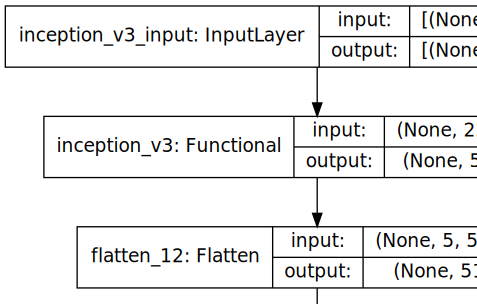

In [56]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

In [62]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_100 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
activation_100 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 112, 112, 64)      51264     
_________________________________________________________________
batch_normalization_101 (Bat (None, 112, 112, 64)    

In [63]:
epochs = 48


checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/48
1801/1801 [==============================] - 350s 194ms/step - loss: 1.9449 - accuracy: 0.2631 - val_loss: 1.7114 - val_accuracy: 0.3189
Epoch 2/48
1801/1801 [==============================] - 346s 192ms/step - loss: 1.6875 - accuracy: 0.3506 - val_loss: 1.5259 - val_accuracy: 0.4104
Epoch 3/48
1801/1801 [==============================] - 347s 193ms/step - loss: 1.5726 - accuracy: 0.3907 - val_loss: 1.3986 - val_accuracy: 0.4619
Epoch 4/48
1801/1801 [==============================] - 347s 193ms/step - loss: 1.4792 - accuracy: 0.4319 - val_loss: 1.3083 - val_accuracy: 0.4993
Epoch 5/48
1801/1801 [==============================] - 344s 191ms/step - loss: 1.4063 - accuracy: 0.4530 - val_loss: 1.2681 - val_accuracy: 0.5169
Epoch 6/48
1801/1801 [==============================] - 346s 192ms/step - loss: 1.3575 - accuracy: 0.4721 - val_loss: 1.2554 - val_accuracy: 0.5242
Epoch 7/48
1801/1801 [==============================] - 344s 191ms/step - loss: 1.3112 - accuracy: 0.4972 - val_

In [64]:
model.save_weights("./model.h5")

In [66]:
scores = model.evaluate_generator(test_set)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


accuracy: 63.91%


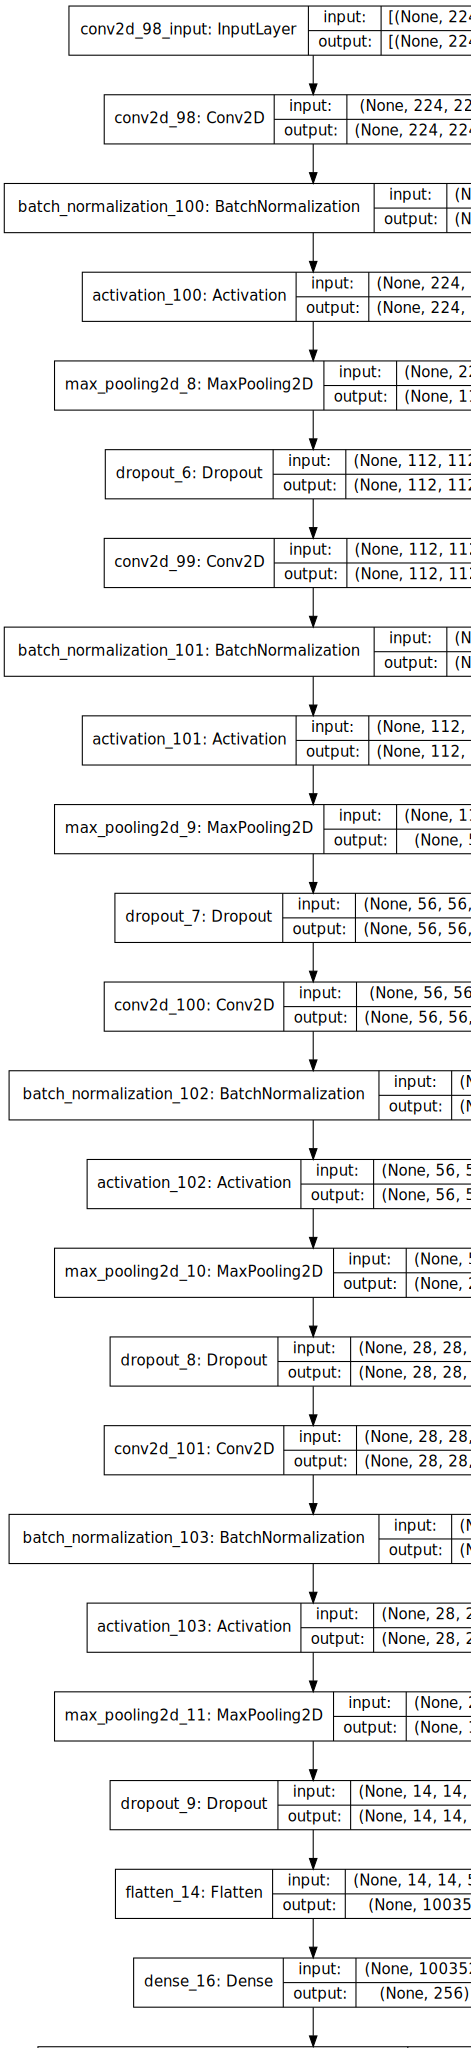

In [67]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

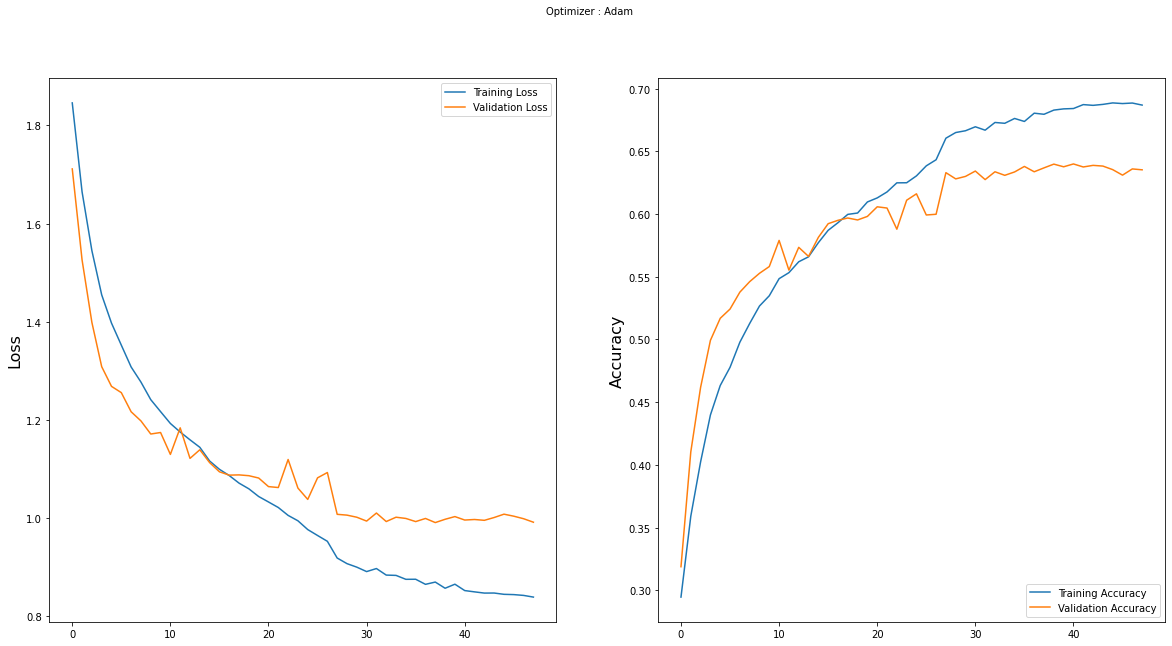

In [68]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

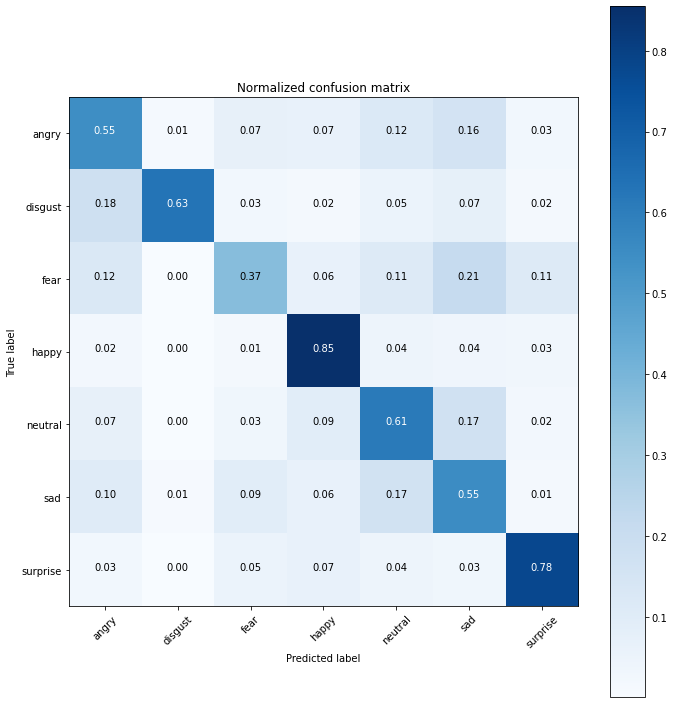

In [163]:
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [167]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)